# Rilevazione degli incidenti stradali con lesioni a persone

La rilevazione degli incidenti stradali con lesioni a persone è svolta a cadenza mensile e rileva tutti gli incidenti stradali verificatisi nell’arco di un anno solare sull’intero territorio nazionale che hanno causato lesioni alle persone (morti entro il 30° giorno e feriti).

Fonte: [ISTAT](https://www.istat.it/).

* Dati: https://www.istat.it/it/archivio/87539
* Metadati: https://www.istat.it/it/archivio/76750


## Importazione dei moduli

In [16]:
import os, re, io
import pandas as pd

## Importazione dei dati

Tutti i file di dati sono originali, scaricati dal sito ufficiale nella cartella `data/`.
Il nome ha la forma `INCSTRAD_Microdati_Anno_[YYYY].txt` con `[YYYY]` uguale a 2010, 2011, 2012, 2013, 2014, 2015, 2016 e 2017.
Si tratta di Tab-separated Values (TSV) con codifica `iso-8859-1`.

In [17]:
data_directory = "../../data"

data_filenames = [
    filename.replace(".txt","")
    for filename in os.listdir(data_directory)
    if filename.endswith(".txt")
]

rows_to_skip = {
    "INCSTRAD_Microdati_Anno_2017": [47753],
    "INCSTRAD_Microdati_Anno_2014": [98015]
}

Pulizia preliminare: i file sono letti come stringhe e vengono eliminati tutti gli spazi vuoti superflui.

In [18]:
data_csvs = {}
for data_filename in data_filenames:
    with open("%s/%s.txt" % (data_directory, data_filename), encoding="iso-8859-1") as f:
        data_csvs[data_filename] = re.sub(r' {2,}', ' ', f.read())

I csv ripuliti sono trasformati in data frames usando la tabulazione come separatore di campo e scartando le righe malformate.

In [19]:
data_tables = {}
for data_filename in data_csvs:
    try:
        data_tables[data_filename] = pd.read_csv(
            io.StringIO(data_csvs[data_filename])
            , sep="\t"
            , skiprows=rows_to_skip[data_filename] if data_filename in rows_to_skip else []
            , error_bad_lines=False
        )
    except Exception as e:
        pass

/home/jenkin/.local/share/virtualenvs/python3--AGPCuUz/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (6,7,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jenkin/.local/share/virtualenvs/python3--AGPCuUz/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jenkin/.local/share/virtualenvs/python3--AGPCuUz/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jenkin/.local/share/virtualenvs/python3--AGPCuUz/lib/python3.7/site-packages/IPython/core/interactiveshell.py:30

I metadati sono estratti dai file originali (da `html` a `tsv`), si trovano nella cartella `meta/` e si chiamano come il nome della variabile a cui si riferiscono.

In [20]:
meta_directory = "../../meta"

meta_filenames = [
    filename.replace(".tsv","")
    for filename in os.listdir(meta_directory)
    if filename.endswith(".tsv")
]

meta_tables = {
    filename: pd.read_csv("%s/%s.tsv" % (meta_directory, filename), sep="\t")
    for filename in meta_filenames
}

## Costruzione del dataset di lavoro

Unione di tutte le singole tabelle e join con i metadati.

In [21]:
all_data = pd.concat([data_tables[filename] for filename in data_tables], sort=False)

for meta_filename in meta_tables:
    all_data = all_data.join(
        meta_tables[meta_filename].add_suffix("_%s" % meta_filename).set_index("Modalità_%s" % meta_filename),
        on=meta_filename
    )

Un'anteprima del dataset di lavoro (quasi 800k righe su 200 colonne), le colonne aggiuntive sono in fondo a destra.

In [22]:
all_data

,anno,provincia,comune,giorno,organo_di_rilevazione,localizzazione_incidente,denominazione_della_strada,tronco_di_strada_o_autostrada,tipo_di_strada,pavimentazione,...,veicolo__c___altri_passegg61,veicolo__c___altri_passegg62,morti_maschi_coinvolti_su_63,morti_femmine_coinvolti_su64,feriti_maschi_coinvolti_su65,feriti_femmine_coinvolti_s66,numero,peso,Descrizione_natura_incidente,Descrizione_condizioni_meteorologiche
0,15,7,22,6.0,2,6,026,1,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Urto con ostacolo,Sereno
1,15,7,31,7.0,2,1,020,12,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Fuoriuscita, sbandamento",Sereno
2,15,7,43,2.0,2,6,026,12,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Urto con ostacolo,Sereno
3,15,7,44,2.0,2,6,026,12,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Fuoriuscita, sbandamento",Sereno
4,15,7,45,3.0,2,6,026,12,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Scontro frontale-laterale,Sereno
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175786,16,10,25,5.0,4,1,000,12,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Scontro frontale-laterale,Sereno
175787,16,10,25,4.0,4,1,000,12,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Infortunio per caduta da veicolo,Pioggia
175788,16,10,25,5.0,4,1,000,12,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Scontro frontale-laterale,Sereno
175789,16,10,25,4.0,4,1,000,12,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tamponamento,Sereno


## Conteggi per categoria (a.k.a. tabella pivot)

Conteggio delle righe per le categorie di interesse per anno.

In [23]:
all_data_per_anno = {
    filename: all_data.groupby("anno")["Descrizione_%s" % filename].value_counts().unstack()
    for filename in meta_tables
}

### Natura incidente

Grafico del numero di incidenti per anno e per natura di incidente.

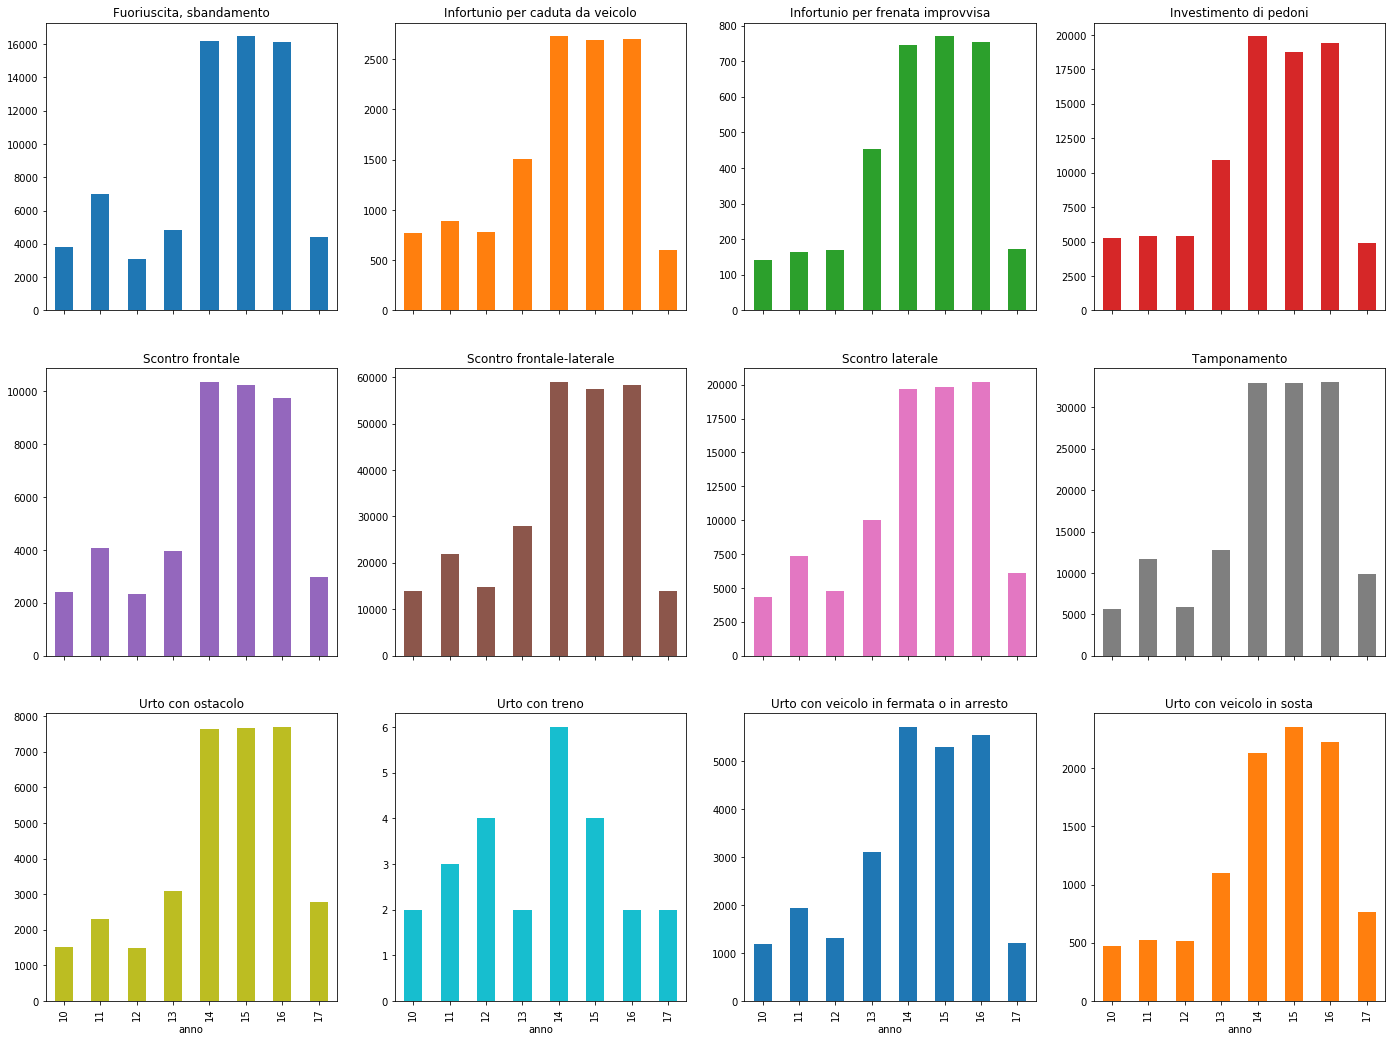

In [24]:
plot_natura_incidente_per_anno = all_data_per_anno["natura_incidente"].plot.bar(
    figsize=(24,18),
    layout=(3,4),
    subplots=True,
    legend=False
)

### Condizioni meteorologiche

Grafico del numero di incidenti per anno e per condizioni meteorologiche.

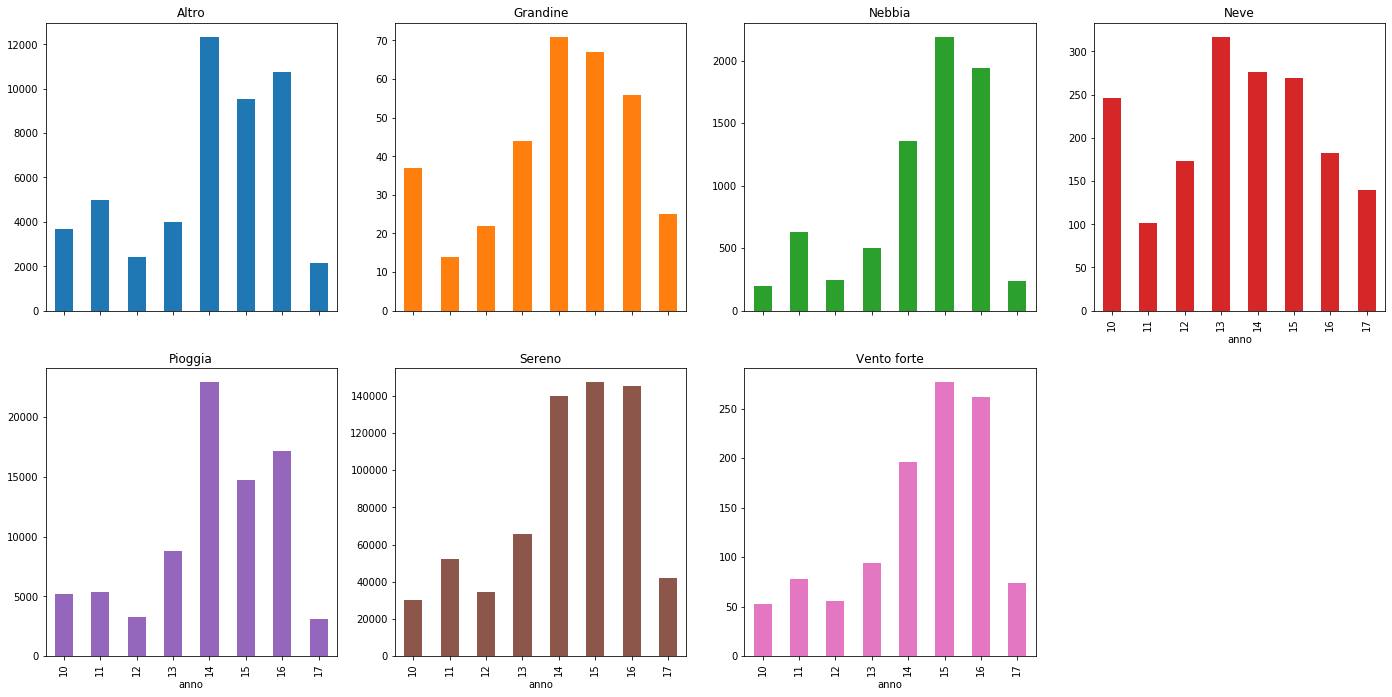

In [25]:
plot_condizioni_meteorologiche_per_anno = all_data_per_anno["condizioni_meteorologiche"].plot.bar(
    figsize=(24,18),
    layout=(3,4),
    subplots=True,
    legend=False
)